In [1]:
%env CUDA_VISIBLE_DEVICES=''

env: CUDA_VISIBLE_DEVICES=''


In [2]:
fig_scale = 1.#2./3.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as onp
import h5py

import jax
from jax import vmap
import jax.numpy as np
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from scipy.stats import norm

from time import time

import os, sys
sys.path.append(os.path.split(os.getcwd())[0])
import scripts.transform_data as transform

In [4]:
plt.rcParams['font.size'] = 14

In [5]:
N_GPU = sum([i.isdigit() for i in os.environ.get('CUDA_VISIBLE_DEVICES')])
if N_GPU>0:
    numpyro.set_platform('gpu')   
    numpyro.set_host_device_count(N_GPU)
    N_chains = N_GPU
else:
    N_chains = 1

print(jax.devices())    

[CpuDevice(id=0)]


# Process Data

In [6]:
# Read in file
d_df = pd.read_csv('../data/IRD/deaths.csv')
# Drop China and Diamond Princess
for c in ['China', 'Diamond Princess']:
    d_df = d_df[d_df['Country/Region']!=c]
d_df['Country/Region'].iloc[~d_df['Province/State'].isnull().values] += ' / '+d_df['Province/State']
d_df = d_df.drop(columns=['Province/State', 'Lat', 'Long'])
d_df.set_index(keys='Country/Region', inplace=True)
# Drop low deaths
d_df = d_df[(d_df.max(axis=1)>10)]

In [7]:
deaths = {}
start_days = np.argmax((d_df.values>3),axis=1)
end_days = np.argmax((d_df.values>1000), axis=1)
for i, country in enumerate(d_df.index):
    if len(d_df.T[country].values[start_days[i]:])>10 and start_days[i]>0:
        if end_days[i]>0:
            deaths[country] = d_df.T[country].values[start_days[i]:end_days[i]]
        else:
#             print('hello')
            deaths[country] = d_df.T[country].values[start_days[i]:]

In [8]:
len(deaths)

105

In [9]:
bcg = pd.read_csv('../data/BCG/BCG_ATLAS.csv', index_col='Country')
NONBCG = ['US', 'Italy', 'Netherlands', 'Belgium', 
          'Lebanon', 'Indonesia', 'Iran']#, 'Ecuador', 'Andorra', 'Luxembourg']
BCG = ['Brazil', 'Peru', 'India', 'Romania', 'Turkey', 
       'Bulgaria', 'Mexico', 'Bosnia and Herzegovina', 'Croatia', 'Slovenia', 'Finland', 
       'United Kingdom', 'Poland', 'Ireland', 'France', 
       'Austria']#, 'Denmark', ], 'Germany', 'Jordan', 'Kazakhstan']
nonbcg = bcg.T[NONBCG].T
bcg = bcg.T[BCG].T

In [10]:
bcg_countries = list(bcg.index.intersection(deaths.keys()))
nonbcg_countries = list(nonbcg.index.intersection(deaths.keys()))
# bcg_countries = list(bcg[bcg['WBIG']<3].index.intersection(deaths.keys()))

In [11]:
nonbcg_countries, bcg_countries, len(nonbcg_countries), len(bcg_countries), len(nonbcg_countries)+len(bcg_countries)

(['US', 'Italy', 'Netherlands', 'Belgium', 'Lebanon', 'Indonesia', 'Iran'],
 ['Brazil',
  'Peru',
  'India',
  'Romania',
  'Turkey',
  'Bulgaria',
  'Mexico',
  'Bosnia and Herzegovina',
  'Croatia',
  'Slovenia',
  'Finland',
  'United Kingdom',
  'Poland',
  'Ireland',
  'France',
  'Austria'],
 7,
 16,
 23)

In [12]:
other = list(set(deaths.keys()) - set(bcg_countries) - set(nonbcg_countries))

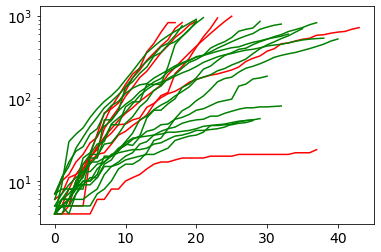

In [13]:
for i, c in enumerate(nonbcg_countries):
    plt.semilogy(deaths[c], 'r')
for i, c in enumerate(bcg_countries):
    plt.semilogy(deaths[c], 'g')

# Bayesian Model

In [19]:
def model():
    
    N_bcg = len(bcg_countries)
    N_nbcg = len(nonbcg_countries)
    N_other = len(other)
    N = N_nbcg + N_bcg + N_other
    
    Di = numpyro.sample('Di', dist.Normal(7.0*np.ones(N), 3.0*np.ones(N)))
    GR = numpyro.sample('GR', dist.Normal(1.33*np.ones(N), 0.5*np.ones(N)))
    
    # Create likelihood for each country    
    for i, country in enumerate(bcg_countries+nonbcg_countries+other):
        dead = deaths[country]
        t = np.arange(len(dead))
        prediction = Di[i]*GR[i]**t
        numpyro.sample(country, dist.Poisson(prediction), # Exponential regression
                       obs=dead)

In [20]:
N_bcg = len(bcg_countries)
N_nbcg = len(nonbcg_countries)
N_other = len(other)
N = N_nbcg + N_bcg + N_other

init_params = {'Di': 7.0*np.ones((N_chains, N)),
               'GR': 1.33*np.ones((N_chains, N)),
              }
if N_chains==1:
    for key in init_params.keys():
        init_params[key] = init_params[key][0]

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=2500, num_chains=N_chains)
rng_key = random.PRNGKey(0)

In [16]:
s = time()
mcmc.run(rng_key, extra_fields=('potential_energy',), init_params=init_params)
print(f'Time taken to compile model and draw samples : {time()-s} s')

Time taken to compile model and draw samples : 1327.2954523563385 s


In [17]:
samples = mcmc.get_samples()
with h5py.File('../data/nb_samples/4.1.1_BCG_EXP_Independent_samples.h5', 'w') as fp:
    for key in samples.keys():
        fp[key] = samples[key]
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     Di[0]     18.55      0.86     18.52     17.12     19.93  17479.77      1.00
     Di[1]      5.18      0.55      5.15      4.27      6.03  12014.87      1.00
     Di[2]      4.63      0.45      4.62      3.90      5.40  12595.43      1.00
     Di[3]     17.54      1.07     17.52     15.85     19.38  15304.66      1.00
     Di[4]     24.23      1.03     24.21     22.58     25.96  19243.62      1.00
     Di[5]      7.17      1.06      7.10      5.41      8.87  10111.83      1.00
     Di[6]      5.53      0.60      5.51      4.50      6.45  11350.39      1.00
     Di[7]      6.50      0.93      6.46      4.92      7.96  11507.06      1.00
     Di[8]      4.96      0.91      4.89      3.42      6.37  10930.44      1.00
     Di[9]      5.50      0.77      5.45      4.22      6.73  10009.85      1.00
    Di[10]      7.50      0.95      7.45      5.97      9.09  11913.73      1.00
    Di[11]      8.68      0

Number of divergences: 0


In [14]:
samples = {}
with h5py.File('../data/nb_samples/4.1.1_BCG_EXP_Independent_samples.h5', 'r') as fp:
    for key in fp.keys():
        samples[key] = fp[(key)][()]

In [31]:
len(bcg_countries+nonbcg_countries+other)

105

In [15]:
for a in zip(bcg_countries+nonbcg_countries+other, zip(np.mean(samples['GR'], axis=0), np.std(samples['GR'], axis=0))):
    print(a)

('Brazil', (1.2108037, 0.0032973615))
('Peru', (1.1943357, 0.007860006))
('India', (1.2013931, 0.00657839))
('Romania', (1.1747957, 0.005176985))
('Turkey', (1.2094319, 0.0032165465))
('Bulgaria', (1.1143051, 0.018644268))
('Mexico', (1.2404972, 0.009718406))
('Bosnia and Herzegovina', (1.1457124, 0.016233815))
('Croatia', (1.1271685, 0.022714186))
('Slovenia', (1.1385868, 0.012755226))
('Finland', (1.1347271, 0.013400131))
('United Kingdom', (1.2877378, 0.005995018))
('Poland', (1.1856058, 0.006358677))
('Ireland', (1.193062, 0.0057407757))
('France', (1.3048974, 0.006158326))
('Austria', (1.15258, 0.0037773568))
('US', (1.2748913, 0.005121838))
('Italy', (1.3230121, 0.0061554834))
('Netherlands', (1.2633687, 0.004652229))
('Belgium', (1.2926202, 0.005668754))
('Lebanon', (1.0834187, 0.010839816))
('Indonesia', (1.1196661, 0.0028590534))
('Iran', (1.2102566, 0.0032803519))
('Congo (Kinshasa)', (1.1103975, 0.029813886))
('Japan', (1.1511865, 0.0019359171))
('Azerbaijan', (1.1671045, 0.

In [16]:
import json

In [17]:
bcg_cov_est = json.load(open('BCG_Coverage_Estimates.json'))

In [20]:
from chainconsumer import ChainConsumer

c = ChainConsumer()

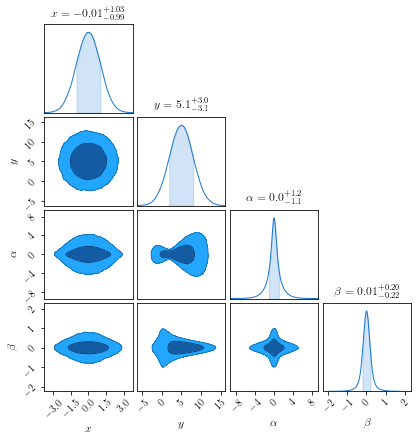

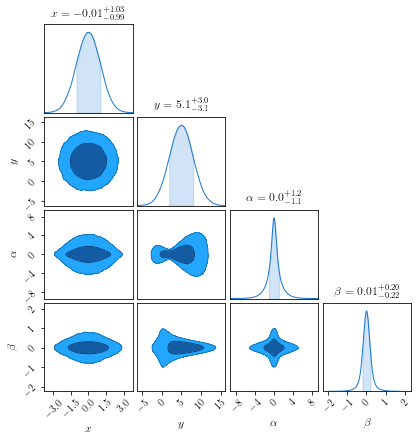

In [25]:
ndim, nsamples = 4, 200000
onp.random.seed(0)

data = onp.random.randn(nsamples, ndim)
data[:, 2] += data[:, 1] * data[:, 2]
data[:, 1] = data[:, 1] * 3 + 5
data[:, 3] /= (np.abs(data[:, 1]) + 1)

# If you pass in parameter labels and only one chain, you can also get parameter bounds
c = ChainConsumer()
c.add_chain(data, parameters=["$x$", "$y$", r"$\alpha$", r"$\beta$"], name="Model A")
c.plotter.plot()

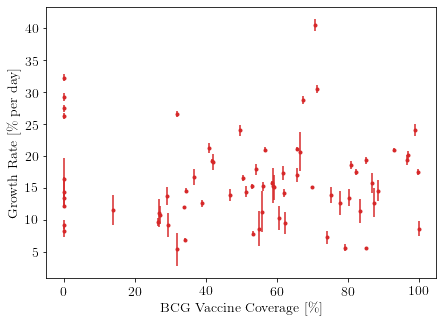

In [34]:
plt.figure(figsize=(7,5))
for i, c in enumerate(bcg_countries+nonbcg_countries+other):
    try:
        plt.errorbar(bcg_cov_est[c], (np.mean(samples['GR'][:,i])-1)*100, 
                     yerr=100*np.std(samples['GR'][:,i]), color='tab:red', fmt='.')
    except:
        continue
plt.xlabel('BCG Vaccine Coverage [\%]')
plt.ylabel('Growth Rate [\% per day]')
plt.savefig('6._BCGvsGR.png', dpi=200)

In [38]:
deaths

{'Afghanistan': array([ 4,  4,  4,  4,  4,  4,  4,  6,  6,  7,  7, 11, 14, 14, 15, 15, 18,
        18, 21, 23, 25]),
 'Albania': array([ 4,  5,  5,  6,  8, 10, 10, 11, 15, 15, 16, 17, 20, 20, 21, 22, 22,
        23, 23, 23, 23, 23, 24, 25]),
 'Algeria': array([  4,   4,   4,   7,   9,  11,  15,  17,  17,  19,  21,  25,  26,
         29,  31,  35,  44,  58,  86, 105, 130, 152, 173, 193, 205, 235,
        256, 275, 293, 313, 326, 336]),
 'Andorra': array([ 6,  8, 12, 14, 15, 16, 17, 18, 21, 22, 23, 25, 26, 26, 29, 29, 31,
        33]),
 'Argentina': array([  4,   4,   4,   6,   8,   9,  13,  18,  19,  23,  27,  28,  36,
         39,  43,  44,  48,  56,  63,  72,  82,  83,  90,  97, 102, 111]),
 'Armenia': array([ 4,  7,  7,  7,  7,  8,  8,  9, 10, 12, 13, 13, 14, 16, 17]),
 'Australia / New South Wales': array([ 4,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,  9, 10,
        12, 12, 16, 18, 21, 21, 21, 22, 23, 24, 25, 25, 25]),
 'Australia / Victoria': array([ 4,  4,  4,  4,  

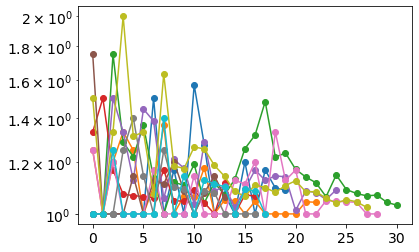

In [55]:
n = 1
for i, c in enumerate(deaths):
    if i==10:
        break
    plt.semilogy((deaths[c][:-n]/deaths[c][n:])**(-1/n), 'o-')

Text(0, 0.5, 'Count')

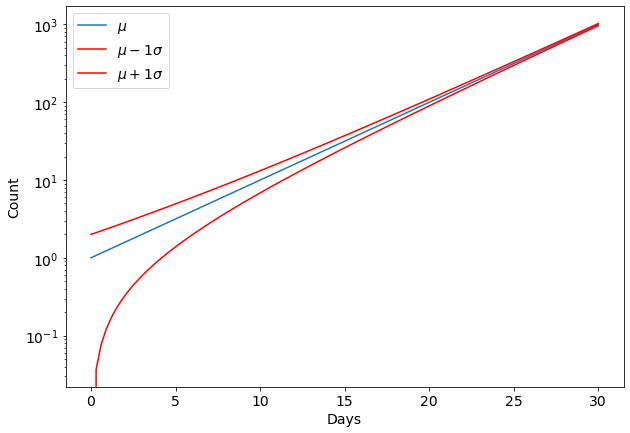

In [73]:
x = np.linspace(0, 30, 100)
a = 0.23
y = np.exp(a*x)

plt.figure(figsize=(10,7))
plt.semilogy(x, y, label=r'$\mu$')
plt.semilogy(x, y-np.sqrt(y), 'r', label=r'$\mu-1\sigma$')
plt.semilogy(x, y+np.sqrt(y), 'r', label=r'$\mu+1\sigma$')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Count')

In [74]:
from scipy.integrate import simps

In [99]:
def dexp(N_p, T_p, tau_0, t_0, t):
    r = T_p/tau_0
    y = (t-tau_0)/T_p
    x = np.linspace(y, 1001)
    int_range = np.linspace(0, 1, 101)
    norm = simps(np.exp(r*int_range*np.exp(-int_range))-1, int_range)
    return N_p*(simps(np.exp(r*x*np.exp(-x))-1, x))/norm

(-100, 10.0)

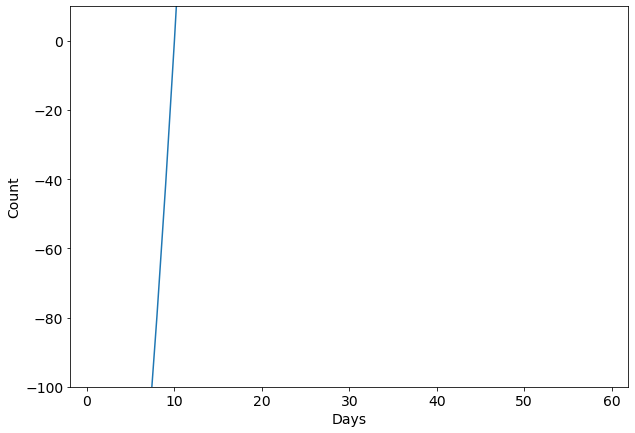

In [141]:
x = np.arange(1, 60)
N_p, T_p, tau_0, t_0 = [1e3, 100, 10, 0]
y = np.array([dexp(N_p, T_p, tau_0, t_0, t) for t in x])

plt.figure(figsize=(10,7))
plt.plot(x, y, label=r'$\mu$')
# plt.semilogy(x, y, label=r'$\mu$')
# plt.semilogy(x, y-np.sqrt(y), 'r', label=r'$\mu-1\sigma$')
# plt.semilogy(x, y+np.sqrt(y), 'r', label=r'$\mu+1\sigma$')
# plt.legend()
plt.xlabel('Days')
plt.ylabel('Count')
plt.ylim(-100, 1e1)
# plt.ylim(1, 1e2*N_p)

In [153]:
def time_dep_growth(a, b, x):
    return ((a/x)**b+1)**x

Text(0, 0.5, 'Count')

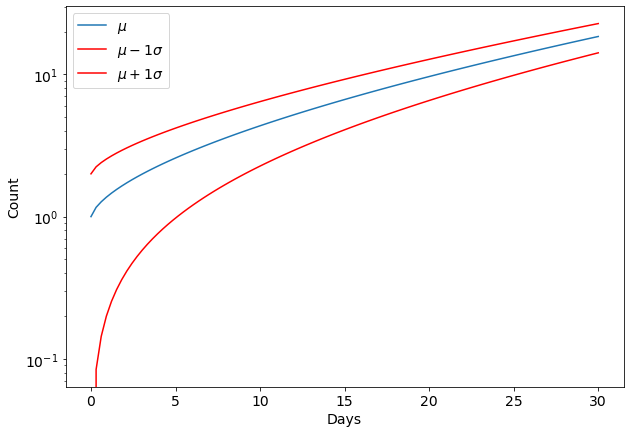

In [161]:
x = np.linspace(0, 30, 100)
a, b = 1e-1, 0.4
y = time_dep_growth(a, b, x)

plt.figure(figsize=(10,7))
plt.semilogy(x, y, label=r'$\mu$')
plt.semilogy(x, y-np.sqrt(y), 'r', label=r'$\mu-1\sigma$')
plt.semilogy(x, y+np.sqrt(y), 'r', label=r'$\mu+1\sigma$')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Count')

In [187]:
def dblexp(a, b, x):
    return np.exp(a*np.exp(-x*b)*x)

Text(0, 0.5, 'Count')

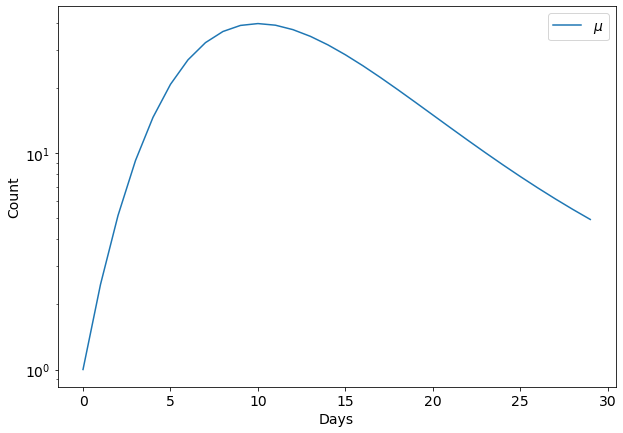

In [221]:
x = np.arange(30)
a, b = 1e0, 1e-1
y = dblexp(a, b, x)

plt.figure(figsize=(10,7))
plt.semilogy(x, y, label=r'$\mu$')
# plt.semilogy(x, y-np.sqrt(y), 'r', label=r'$\mu-1\sigma$')
# plt.semilogy(x, y+np.sqrt(y), 'r', label=r'$\mu+1\sigma$')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Count')

In [216]:
def step_inter(Di, GR0, GR1, t0, t):
    print(len(GR0**t[t>=t0]))
    return np.concatenate([Di*GR0**t[t<t0], Di*GR0**t[t<t0][-1]*GR1**(t[t>=t0]-t[t<t0][-1])])

20


Text(0, 0.5, 'Count')

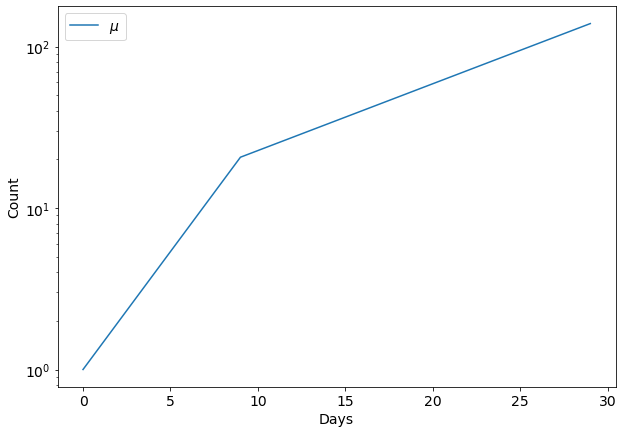

In [217]:
x = np.arange(30)
a, b = 1e0, 1e-2
y = step_inter(1, 1.4, 1.1, 10, x)

plt.figure(figsize=(10,7))
plt.semilogy(x, y, label=r'$\mu$')
# plt.semilogy(x, y-np.sqrt(y), 'r', label=r'$\mu-1\sigma$')
# plt.semilogy(x, y+np.sqrt(y), 'r', label=r'$\mu+1\sigma$')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Count')

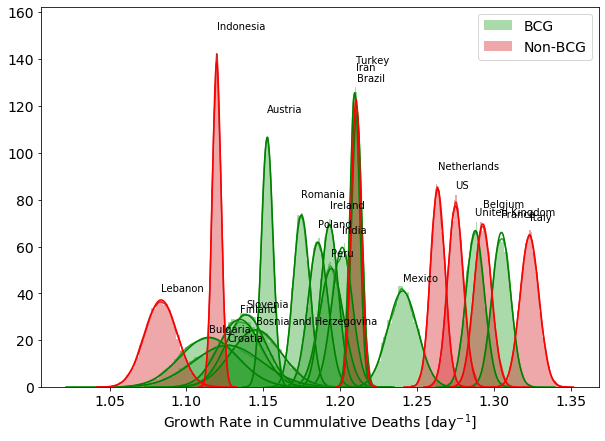

In [18]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
for i, c in enumerate(bcg_countries):
    mn = np.mean(samples['GR'][:,i])
    std = np.std(samples['GR'][:,i])
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), c, fontsize=10)
    if i==0:
        sns.distplot(samples['GR'][:,i], bins=50, fit=norm, 
                     fit_kws={'color':'green'}, color='tab:green', label='BCG')
    else:
        sns.distplot(samples['GR'][:,i], bins=50, fit=norm, 
                     fit_kws={'color':'green'}, color='tab:green')
        
for i, c in enumerate(nonbcg_countries):
    mn = np.mean(samples['GR'][:,N_bcg+i])
    std = np.std(samples['GR'][:,N_bcg+i])
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), c, fontsize=10)
    if i==0:
        sns.distplot(samples['GR'][:,N_bcg+i], bins=50, fit=norm, 
                     fit_kws={'color':'red'}, color='tab:red', label='Non-BCG')
    else:
        sns.distplot(samples['GR'][:,N_bcg+i], bins=50, fit=norm, 
                     fit_kws={'color':'red'}, color='tab:red')
    
plt.legend()
plt.xlabel(r'Growth Rate in Cummulative Deaths [day$^{-1}$]')
plt.savefig('../plots/4.1_Death_Growth_Rate.png', dpi=200)

# Example Plots

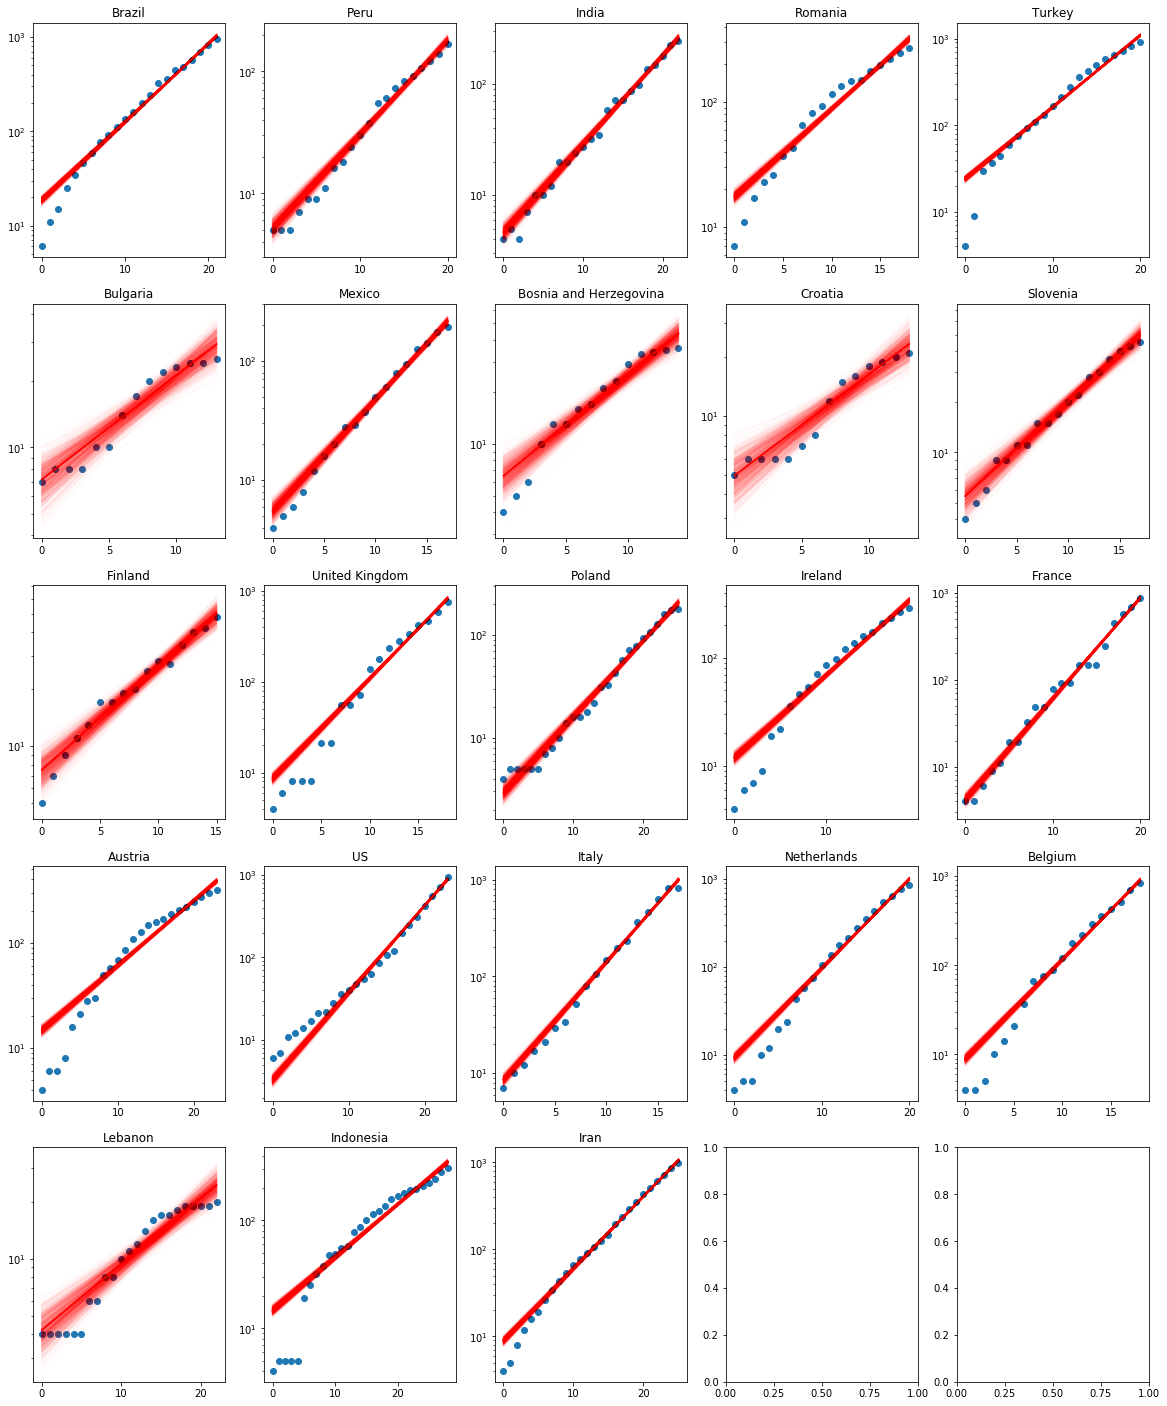

In [19]:
plt.rcParams['font.size'] = 10
fig,ax = plt.subplots(5, 5, figsize=(fig_scale*20,fig_scale*25))
a = ax.flatten()
for i, c in enumerate(bcg_countries+nonbcg_countries):
    t = np.arange(len(deaths[c]))
    a[i].set_title(c)
    a[i].semilogy(deaths[c], 'o')
    a[i].semilogy(np.mean(samples['Di'][:,i])*np.mean(samples['GR'][:,i])**t, 'r')
    a[i].semilogy((samples['Di'][::10,i:i+1]*samples['GR'][::10,i:i+1]**t[None,:]).T, 'r', alpha=0.01)
    
plt.savefig('../plots/4.1_ExampleFits.png', dpi=200)     
plt.rcParams['font.size'] = 14

# Trace Plots

Text(0, 0.5, 'Growth Rate')

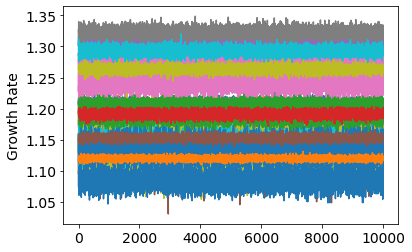

In [20]:
plt.plot(samples['GR'])
plt.ylabel('Growth Rate')

Text(0, 0.5, 'Initial Deaths')

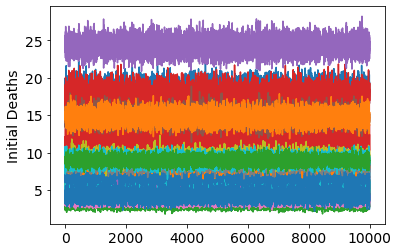

In [21]:
plt.plot(samples['Di'])
plt.ylabel('Initial Deaths')